In [50]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from matplotlib import pyplot as plt
%matplotlib inline

In [51]:
class RegressionNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)  # Adds dropout of 30%
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)  # Adds dropout of 30%
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.1)  # Adds dropout of 30%
        self.fc4 = nn.Linear(hidden_size, 1)
        # self.relu4 = nn.ReLU()    # ! why, why not?

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu1(self.fc1(x))
        # x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        # x = self.dropout2(x)
        x = self.relu3(self.fc3(x))
        # x = self.dropout3(x)
        x = self.fc4(x)
        return x

DNN_12_05_2024 = RegressionNN(input_size=28, hidden_size=50)
DNN_12_05_2024.load_state_dict(torch.load('RegressionNN_12_05_2024_input_size_28_hidden_size_50_hidden_layers_3_epochs_100.pt'))


<All keys matched successfully>

In [52]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model instantiation
model: nn.Module = DNN_12_05_2024.to(device)

# Loss and optimizer
criterion: nn.Module = nn.MSELoss()
optimizer: torch.optim.Optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [53]:
symbol = 'AAPL'

In [35]:
train_df = pd.read_excel(
    r'C:\Users\candr\Documents\masters\SecurityAnalysisDNN\src\SecurityAnalysisDNN\data\preparedData\{dateStr}\train_{symbol}.xlsx')
val_df = pd.read_excel(r'C:\Users\candr\Documents\masters\SecurityAnalysisDNN\src\SecurityAnalysisDNN\data\preparedData\{dateStr}\val_{symbol}.xlsx')

if 'index' in train_df.columns.to_list():
    train_dates = train_df.loc[:, 'index']
    val_dates = val_df.loc[:, 'index']
    train_df = train_df.drop(columns=['index'])
    val_df = val_df.drop(columns=['index'])
    
train_df.shape, val_df.shape

((100, 29), (25, 29))

In [37]:
target_column = 'Close Price'
input_columns = train_df.columns.to_list()
input_columns.remove(target_column)

train_inputs = train_df[input_columns].values
train_targets = train_df[target_column].values

val_inputs = val_df[input_columns].values
val_targets = val_df[target_column].values

In [38]:
scaler = StandardScaler()
scaler.fit(train_inputs)

train_inputs = scaler.transform(train_inputs)
# train_targets = scaler.transform(train_targets)

val_inputs = scaler.transform(val_inputs)
# val_targets = scaler.transform(val_targets)

In [39]:
print(f"input_train_data.shape: {train_inputs.shape}, train_targets.shape: {train_targets.shape}")
print(f"input_val_data.shape: {val_inputs.shape}, val_targets.shape: {val_targets.shape}")

input_train_data.shape: (100, 28), train_targets.shape: (100,)
input_val_data.shape: (25, 28), val_targets.shape: (25,)


In [40]:
input_train_data_tensor = torch.tensor(train_inputs, dtype=torch.float32)
train_targets_tensor = torch.tensor(train_targets.reshape((-1,1)), dtype=torch.float32)
input_val_data_tensor = torch.tensor(val_inputs, dtype=torch.float32)
val_targets_tensor = torch.tensor(val_targets.reshape((-1,1)), dtype=torch.float32)

# Creating datasets
train_dataset = TensorDataset(input_train_data_tensor, train_targets_tensor)
val_dataset = TensorDataset(input_val_data_tensor, val_targets_tensor)

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [41]:
# Actual vs predicted for the test prices

def test_predictions(model, criterion, loader):
    predictions = []
    test_losses = []
    actual = []

    model.eval()
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets: torch.Tensor
        p: torch.Tensor = model(inputs)
        loss: torch.Tensor = criterion(p, targets)
        test_losses.append(loss.item())

        predictions.extend(p.detach().numpy())
        actual.extend(targets.numpy())
    
    return predictions, actual, test_losses

In [42]:
# todo loader
val_predictions, val_real, val_losses = test_predictions(model, criterion, val_loader)
train_predictions, train_real, test_losses = test_predictions(model, criterion, train_loader)

NameError: name 'symbol' is not defined

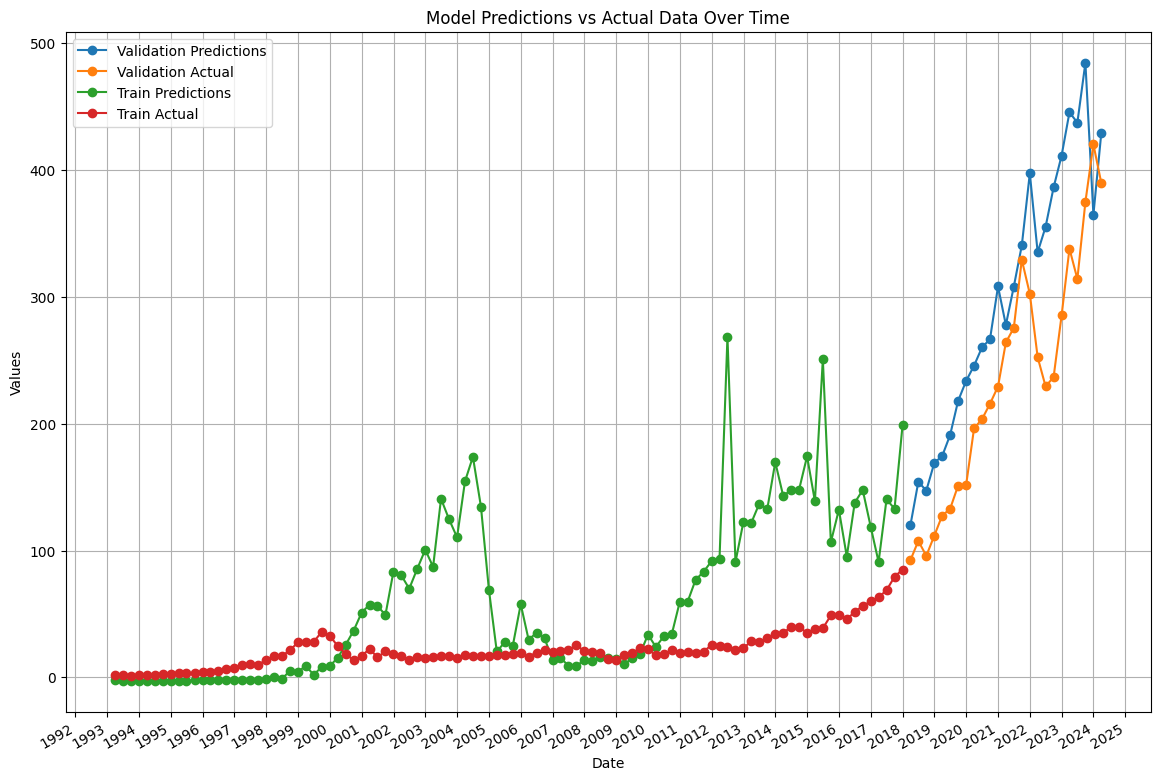

In [49]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming val_dates, val_predictions, val_real, train_dates, train_predictions, train_real are defined
fig = plt.figure(figsize=(14, 10))
plt.plot_date(x=val_dates, y=val_predictions, label='Validation Predictions', linestyle='-')
plt.plot_date(x=val_dates, y=val_real, label="Validation Actual", linestyle='-')
plt.plot_date(x=train_dates, y=train_predictions, label='Train Predictions', linestyle='-')
plt.plot_date(x=train_dates, y=train_real, label="Train Actual", linestyle='-')

# Format the x-axis to display dates more clearly
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Improve readability of the dates by rotating them
plt.gcf().autofmt_xdate()

# Add titles and labels
plt.title('Model Predictions vs Actual Data Over Time')
plt.xlabel('Date')
plt.ylabel('Values')

# Adding grid lines for better readability
plt.grid(True)
plt.legend()
plt.savefig(f'C:/Users/candr/Documents/masters/SecurityAnalysisDNN/src/SecurityAnalysisDNN/models/deepLearning/ANNs/results/{symbol}_{dateStr}.png')
